In [13]:
from wfield import *
import os 
import h5py
import pandas as pd
from scipy.io import loadmat
from scipy.signal import savgol_filter

In [14]:
directory = "C:/Behavior/Animals/"
animal = "FV-4/"
maze = "SD/"
session = "12-Jul-2022/"
file = "{}/"
sync = "sync"
path_sync = os.path.join(directory, animal, maze, session, sync)
os.chdir(path_sync)
print(path_sync)

C:/Behavior/Animals/FV-4/SD/12-Jul-2022/sync


In [15]:
df = pd.read_csv('All_data.csv')

In [16]:
group_act_load = np.load('group_act.npy', allow_pickle = True)

In [17]:
lmarks = load_allen_landmarks('dorsal_cortex_landmarks.json')
ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')
# the reference is in allen CCF space and needs to be converted
# this converts to warped image space (accounting for the transformation)
ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                      resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])
atlas, areanames, brain_mask = atlas_from_landmarks_file('dorsal_cortex_landmarks.json') # this loads the atlas in transformed coords

# this converts the reference to image space (unwarped)
atlas_im, areanames, brain_mask = atlas_from_landmarks_file('dorsal_cortex_landmarks.json',do_transform = True) # this loads the untransformed atlas
ccf_regions_im = allen_transform_regions(lmarks['transform'],ccf_regions_reference,
                                        resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])

In [18]:
#avg length of correct, incorrect trials 
df['time diff'] = df['end frame'] - df['start frame']
avg_length_trial = df[df['correct'] == 1]['time diff'].mean(), df[df['correct'] == 0]['time diff'].mean()

In [19]:
correct_time = avg_length_trial[0]-90
incorrect_time = avg_length_trial[1]-150


Text(0, 0.5, 'frames')

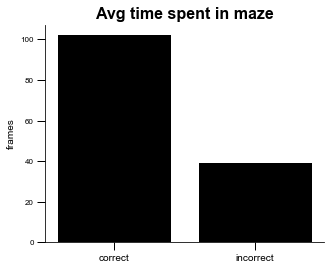

In [20]:
fig, axs = plt.subplots(1, 1, figsize = (5,4))
axs.bar([1,2], [correct_time, incorrect_time])
axs.locator_params(axis='x', nbins=2)
axs.set_xticks([1,2])
axs.set_xticklabels(['correct', 'incorrect'], fontsize=10)
axs.set_title('Avg time spent in maze', fontsize=16)
axs.set_ylabel('frames',fontsize=10)

In [39]:
df[(df['correct'] == 1) & (df['start frame'] > 0) & (df['end frame'] > 0)].shape

(146, 7)

In [22]:
#data struc with just incorrect trials 
trial_activity_incorrect = []
for i in list(df[(df['correct'] == 0) & (df['start frame'] > 0)].index):
    trial_activity_incor = group_act_load[i]
    trial_activity_incorrect.append(trial_activity_incor)
trial_activity_incorrect = np.array(trial_activity_incorrect, dtype=object)

In [23]:
#data struc with just correct trials 
trial_activity_correct = []
for i in list(df[(df['correct'] == 1) & (df['start frame'] > 0)] .index):
    trial_activity_cor = group_act_load[i]
    trial_activity_correct.append(trial_activity_cor)
trial_activity_correct = np.array(trial_activity_correct, dtype=object)

In [24]:
def avgNestedLists(nested_vals):
    """
    Averages a 2-D array and returns a 1-D array of all of the columns
    averaged together, regardless of their dimensions.
    """
    output = []
    maximum = 0
    for lst in nested_vals:
        if len(lst) > maximum:
            maximum = len(lst)
    for index in range(maximum): # Go through each index of longest list
        temp = []
        for lst in nested_vals: # Go through each list
            if index < len(lst): # If not an index error
                temp.append(lst[index])
        output.append(np.nanmean(temp))
    return output

In [25]:
trial_act = trial_activity_correct[4][5]
corr_iti = len(trial_act)-90
incorr_iti = len(trial_act)-150

In [26]:
len(trial_act)

238

In [27]:
corr_iti

148

In [28]:
trial_act[corr_iti:len(trial_act)].shape

(90,)

In [35]:
def mean_act_for_area_corr(area): 
    first_second_activity_correct = []
    trials = list(range(trial_activity_correct.shape[0]))
    for i in trials:
        x = trial_activity_correct[i][area][:120]
        first_second_activity_correct.append(x)
    first_second_activity_correct = np.array(first_second_activity_correct, dtype=object)
    mean = np.nanmean(first_second_activity_correct, axis=0)
    return mean

In [36]:
def mean_act_for_area_incorr(area): 
    first_second_activity_incorrect = []
    trials = list(range(trial_activity_incorrect.shape[0]))
    for i in trials:
        x = trial_activity_incorrect[i][area][:120]
        first_second_activity_incorrect.append(x)
    first_second_activity_incorrect = np.array(first_second_activity_incorrect, dtype=object)
    mean = np.nanmean(first_second_activity_incorrect, axis=0)
    return mean

In [40]:
def fig_trial():
    #Figure for multi ROI activity during a trial 
    #area = [2,3,8,10,20,32]
    area = [2,3,20,31]

    fig, axs = plt.subplots(2, 1, figsize = (5,4))
    fig.set_dpi(200.0)
    for i in area:
        trial_act = mean_act_for_area_corr(i)
        axs[0].plot(trial_act, label = ccf_regions_im['acronym'][i])
        axs[0].set_xticks(ticks=[i * 30 for i in list(range(int(len(trial_act)/30+2)))]) #ticks every 30th frame for axis 
        axs[0].legend()
        axs[0].legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0,  prop={'size': 6})
        axs[0].set_title('correct trials n=146', fontsize=8)
        axs[0].set_xlabel('frames')
        axs[0].set_ylabel('z-scored deltaF/F')
        axs[0].locator_params(axis='x', nbins=6)
        axs[0].locator_params(axis='y', nbins=2)
        axs[0].set_ylim([-0.5,0.5]);
    for i in area:
        trial_act = mean_act_for_area_incorr(i)
        axs[1].plot(trial_act, label = ccf_regions_im['acronym'][i]) 
        axs[1].set_xticks(ticks=[i * 30 for i in list(range(int(len(trial_act)/30+2)))]) #ticks every 30th frame for axis 
        #axs[1].legend()
        #axs[1].legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0,  prop={'size': 6})
        axs[1].locator_params(axis='x', nbins=6)
        axs[1].locator_params(axis='y', nbins=2)
        axs[1].set_title('incorrect trials n=46', fontsize=8)
        axs[1].set_xlabel('frames')
        axs[1].set_ylabel('z-scored deltaF/F')
        axs[1].set_ylim([-0.5,0.5]);

    fig.tight_layout()

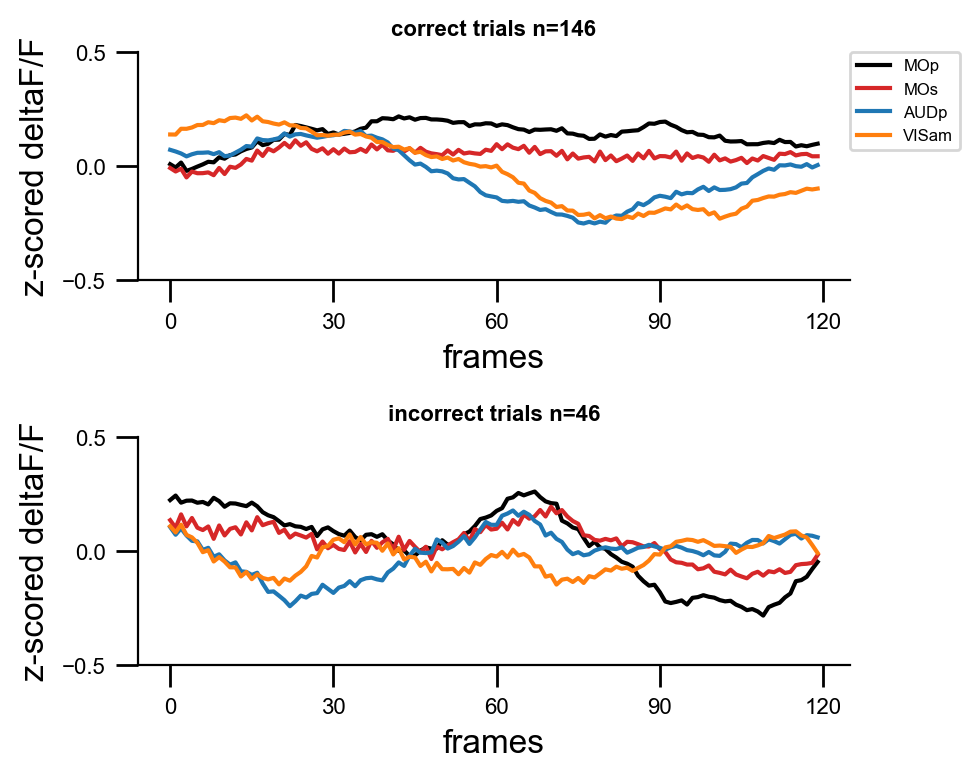

In [41]:
fig_trial()

In [33]:
corr_avg_act = []
for i in list(range(33)):
    x = mean_act_for_area_corr(i)
    #x = np.array(x, dtype=object)
    corr_avg_act.append(x)
#corr_avg_act = np.array(corr_avg_act)
np.save('corr_avg_act', corr_avg_act)

In [34]:
incorr_avg_act = []
for i in list(range(33)):
    x = mean_act_for_area_incorr(i)
    #x = np.array(x, dtype=object)
    incorr_avg_act.append(x)
#corr_avg_act = np.array(corr_avg_act)
np.save('incorr_avg_act', incorr_avg_act)